# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

**Описание данных**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

**Цель исследования**

Построить модель с максимально большим значением accuracy, доведя долю правильных ответов по крайней мере до 0.75. 

**Ход исследования**

Данные о тарифах получены их файла `datasets/users_behavior.csv`. В проекте мы изучим данные, разделим файлы на выборки, исследуем разлчные модели, проверим качество на тестовой выборке, а также проведем исследование на вменяемость модели.

Таким образом, исследование прйдет в ряд этапов:
- открытие файла и изучение данных; 
- разделение исходных данных на обучающую, валидационную и тестовую выборки;
- исследование качества разных моделей, выбор модели с наибольшим *accuracy*;
- проверка качества наилучшей модели на тестовой выборке;
- проверка модели на вменяемость;
- формулировка выводов.

## Откройте и изучите файл

Предварительно загрузим необходимые в работе библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

Далее откроем файл `users_behavior.csv` и посмотрим на его данные с помощью раличных методов *pandas*.

In [2]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')
except:
    df = pd.read_csv('D:/learn_data/users_behavior.csv')

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Как мы видим, по сути колонки `'calls'` и `'messages'` содержат целые числа (что логично, так как нельзя сделать ползвонка или отправить четверть сообщения), в связи с чем для удобства переведем тип данных в этих колонках в `int`.

In [5]:
df['calls'] = df['calls'].astype('int')
df['messages'] = df['messages'].astype('int')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


Хоть у нас и сказано, что предобработка данных не требуется, но, на всякий случай, проверим датафрейм на отсутствие дубликатов. 

In [6]:
df.duplicated().sum()

0

**Вывод:** Как мы видим, у нас имеется база данных, содержащая сведения о 2314 случаях, в которых имееются сведения о звонках, их продолжительности, сообщениях и трафике, а также об использовавшемся тарифе (что и является целевым признаком исследования). В тоже время следует заметить, что данные по тарифам неравномерны, а разделены в соотношении примерно 3 к 7, поскольку тариф "Ультра" использовался лишь чуть более 30% пользователей, тогда как остальные использовали тариф "Смарт" (это создаст некоторые сложности и при проверке модели на адекватность, но данный вопрос будем решать позже).  

In [7]:
short_list = ['calls', 'minutes', 'messages', 'mb_used', 'is_ultra']
while len(short_list) > 1:
    for i in range(len(short_list) - 1):
        print(f'Коэффициент корреляции показателя {short_list[-1]} от столбца {short_list[i]} составляет: {df[short_list[-1]].corr(df[short_list[i]])}')
    short_list.pop()

Коэффициент корреляции показателя is_ultra от столбца calls составляет: 0.2071215589860754
Коэффициент корреляции показателя is_ultra от столбца minutes составляет: 0.206954638121695
Коэффициент корреляции показателя is_ultra от столбца messages составляет: 0.20382983853553618
Коэффициент корреляции показателя is_ultra от столбца mb_used составляет: 0.1985676456197425
Коэффициент корреляции показателя mb_used от столбца calls составляет: 0.2864415120350544
Коэффициент корреляции показателя mb_used от столбца minutes составляет: 0.2809669350882149
Коэффициент корреляции показателя mb_used от столбца messages составляет: 0.19572112095582148
Коэффициент корреляции показателя messages от столбца calls составляет: 0.1773845012176953
Коэффициент корреляции показателя messages от столбца minutes составляет: 0.17311022580969077
Коэффициент корреляции показателя minutes от столбца calls составляет: 0.9820832355742293


## Разбейте данные на выборки

С учетом того, что нам необходимо разделить данные на три выборки (обучающую, валидационную и тестовую), предлагаю разделить их в соотношении **3 : 1 : 1** (для чего необходимо выделить 20% данных для тестовой выборки, а остальные 80% разделить в соотношении 1 (валидационная часть) : 3 (обучающая часть)). Также сразу же подготовим данные к обучению моделей, выделив блоки с целевыми признаками (сведения о тарифе) в отдельные переменные. Сразу же, в целях возможности адекватной поверки проекта, закрепим псевдослучайность для наших алгоритмов, выбрав параметр `random_state` как *888*.   

In [8]:

df_tmp, df_test = train_test_split(df, test_size=0.20, random_state=888)
df_train, df_valid = train_test_split(df_tmp, test_size=0.25, random_state=888)


features_train = df_train.drop(['is_ultra'], axis=1)
target_train = df_train['is_ultra']

features_valid = df_valid.drop(['is_ultra'], axis=1)
target_valid = df_valid['is_ultra']

features_test = df_test.drop(['is_ultra'], axis=1)
target_test = df_test['is_ultra']

**Вывод:** Мы разделили данные на три выбкри (обучающую, валидационную  тестовую), а также выделили целевой признак (тариф). Для определения псевдослучайности использовали аргумент *888*. 

In [9]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(1928, 5)
(643, 5)
(643, 5)


## Исследуйте модели

Приступим к обучению моделей на обучающих выборках и выбору наболее продуктивной модели по параметру `accuracy` по валидационной выборке. Поскольку перед нами стоит типичная задача бинарной классификации, предлагаю использовать следующие модели: дерево решений, случайный лес и логистическую регрессию. 

Давайте начнем с моделей дерева решений. Закрепим псевдослучайность аргументом *888* и проверим качество обучения по показателю точности (`accuracy`) с указанием в качестве вариантов глубины дерева от **1** до **10**. Также посмотрим изменения качества моделей в завсимости от глубины дерева на графике. 

Accuracy наилучшей модели на валидационной выборке: 0.8211508553654744 Глубина дерева: 5


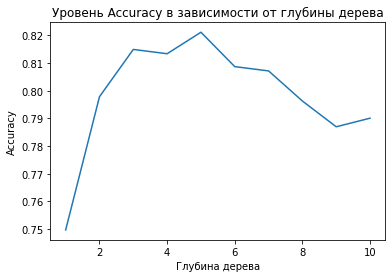

In [10]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
linegraf = []
indexgraf = []

for depth in range(1, 11):
    model_tree = DecisionTreeClassifier(random_state=888, max_depth=depth)
    
    model_tree.fit(features_train, target_train) 
    tree_pred = model_tree.predict(features_valid) 
    
    result = metrics.accuracy_score(target_valid, tree_pred) 
    
    if result > best_result_tree:
        best_model_tree = model_tree
        best_result_tree = result
        best_depth_tree = depth
    linegraf.append(result) 
    indexgraf.append(depth)

line = pd.Series(linegraf, index=indexgraf)

print("Accuracy наилучшей модели на валидационной выборке:", best_result_tree, "Глубина дерева:", best_depth_tree)
line.plot(title='Уровень Accuracy в зависимости от глубины дерева', xlabel='Глубина дерева', ylabel='Accuracy');

Как мы видим, у нас, в целом, получен неплохой результат более 82% модели дерева решений при глубине дерева **5**. Давайте также взглянем на другие показатели качества выбранной модели дерева решений (precision, recall, f1). 

In [11]:
tree_pred = best_model_tree.predict(features_valid) 

print("Точность предсказаний тарифа 'Ультра' модели дерева:", metrics.precision_score(target_valid, tree_pred, pos_label=1))
print("Точность предсказаний тарифа 'Смарт' модели дерева:", metrics.precision_score(target_valid, tree_pred, pos_label=0))
print("Полнота предсказаний модели дерева:", metrics.recall_score(target_valid, tree_pred))
print("F1 предсказаний модели дерева:", metrics.f1_score(target_valid, tree_pred))

Точность предсказаний тарифа 'Ультра' модели дерева: 0.8717948717948718
Точность предсказаний тарифа 'Смарт' модели дерева: 0.8098859315589354
Полнота предсказаний модели дерева: 0.504950495049505
F1 предсказаний модели дерева: 0.6394984326018809


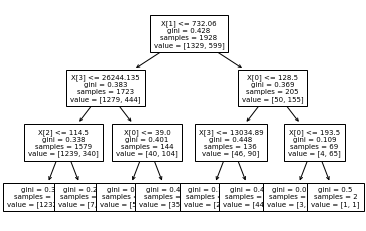

In [12]:
tree.plot_tree(DecisionTreeClassifier(random_state=888, max_depth=3).fit(features_train, target_train), fontsize=7);

Как мы видим, с точностью у данной модели дерева решений все обстоит в целом, неплохо, но показатели полноты и f1 несколько хуже.

Далее будем обучать модели случайного леса. Закрепим псевдослучайность аргументом *888* и проверим качество обучения по показателю точности (`accuracy`) с указанием в качестве вариантов количетсво оценщиков от **10** до **50** (с шагом **10**) и глубины дерева от **1** до **15**. В параметре `ctiterion` укажем `'gini'` (в дальнешем посмотрим на варианты случайного леса с друим критерием). Также посмотрим изменения качества моделей в завсимости от изменений глубины дерева на графике. 

In [13]:
%%time
best_model_forest = None
best_result_forest = 0
best_est_forest = 0
best_depth_forest = 0

lineforest = []
indexforest = []
counter = 1

for est in range(10, 51, 10):
    for depth in range (1, 16):
        model_forest = RandomForestClassifier(random_state=888, criterion='gini', n_estimators=est, max_depth=depth)
        
        model_forest.fit(features_train, target_train) 
        
        result = model_forest.score(features_valid, target_valid) 
        
        if result > best_result_forest:
            best_model_forest = model_forest
            best_result_forest = result
            best_est_forest = est
            best_depth_forest = depth
        
        lineforest.append(result)
        indexforest.append(counter)
        counter += 1

line = pd.Series(lineforest, index=indexforest)

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest, "Количество деревьев:"
      , best_est_forest, "Максимальная глубина:", best_depth_forest)

Accuracy наилучшей модели на валидационной выборке: 0.8429237947122862 Количество деревьев: 30 Максимальная глубина: 12
CPU times: user 7.12 s, sys: 80.4 ms, total: 7.2 s
Wall time: 7.22 s


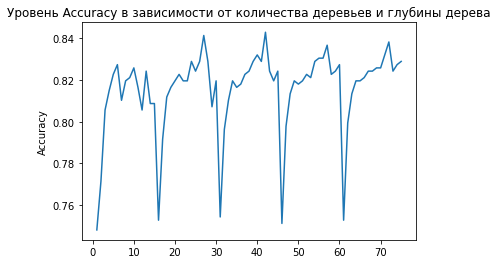

In [14]:
line.plot(title='Уровень Accuracy в зависимости от количества деревьев и глубины дерева', ylabel='Accuracy');

Как мы видим, наиучший показатель `accuracy` (более 84%) достигается при 30 деревьях (оценщиках) с глубиной дерева **12**.

Теперь взглянем, как работают аналогичные модели случайного леса при указании в параметре `criterion` в качестве аргумента `'entropy'`.

In [15]:
%%time
best_model_forest_2 = None
best_result_forest_2 = 0
best_est_forest_2 = 0
best_depth_forest_2 = 0

lineforest = []
indexforest = []
counter = 1

for est in range(10, 51, 10):
    for depth in range (1, 16):
        model_forest = RandomForestClassifier(random_state=888, criterion='entropy', n_estimators=est, max_depth=depth)
        
        model_forest.fit(features_train, target_train) 
        
        result = model_forest.score(features_valid, target_valid) 
        
        if result > best_result_forest_2:
            best_model_forest_2 = model_forest
            best_result_forest_2 = result
            best_est_forest_2 = est
            best_depth_forest_2 = depth
        
        lineforest.append(result)
        indexforest.append(counter)
        counter += 1

line = pd.Series(lineforest, index=indexforest)

print("Accuracy наилучшей модели на валидационной выборке:", best_result_forest_2, "Количество деревьев:"
      , best_est_forest_2, "Максимальная глубина:", best_depth_forest_2)

Accuracy наилучшей модели на валидационной выборке: 0.8367029548989113 Количество деревьев: 20 Максимальная глубина: 9
CPU times: user 9.29 s, sys: 66.8 ms, total: 9.36 s
Wall time: 9.4 s


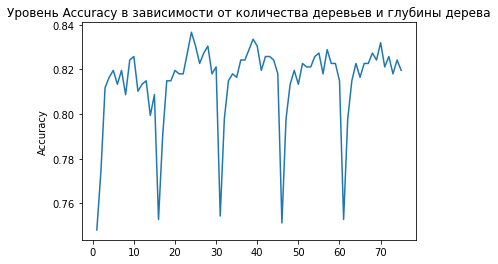

In [16]:
line.plot(title='Уровень Accuracy в зависимости от количества деревьев и глубины дерева', ylabel='Accuracy');

Как видно, наилучший показатель `accuracy` в данном случае достигается при 20 оценщиках с глубиной дерева 9. Но в тоже время данный показатель (83,67%) несколько хуже полученного нами ранее с критерием `'gini'` (84,29%), в связи с чем будем использовать модель случайного леса, полученную ранее. Проверим эту модель по другим показателям качества.  

In [17]:
forest_pred = best_model_forest.predict(features_valid) 

print("Точность предсказаний тарифа 'Ультра' модели случайного леса:", 
      metrics.precision_score(target_valid, forest_pred, pos_label=1))
print("Точность предсказаний тарифа 'Смарт' модели случайного леса:", 
      metrics.precision_score(target_valid, forest_pred, pos_label=0))
print("Полнота предсказаний модели случайного леса:", metrics.recall_score(target_valid, forest_pred))
print("F1 предсказаний модели случайного леса:", metrics.f1_score(target_valid, forest_pred))

Точность предсказаний тарифа 'Ультра' модели случайного леса: 0.8796992481203008
Точность предсказаний тарифа 'Смарт' модели случайного леса: 0.8333333333333334
Полнота предсказаний модели случайного леса: 0.5792079207920792
F1 предсказаний модели случайного леса: 0.698507462686567


Как мы видим, с точностью у выбранной модели случайного леса все обстоит в целом, неплохо, но показатели полноты и f1 несколько хуже (хотя и лучше, чем у модели дерева решений).

Далее обучим модель логистической регрессии, после чего рассмотрим показатели ее качества.

In [18]:
model_logistic = LogisticRegression(random_state=888, solver='liblinear', max_iter=1000)

model_logistic.fit(features_train, target_train) 
logistic_pred = model_logistic.predict(features_valid)
result_logistic = model_logistic.score(features_valid, target_valid) 

print("Accuracy модели логической регрессии на валидационной выборке:", result_logistic)

Accuracy модели логической регрессии на валидационной выборке: 0.7076205287713841


In [19]:
print("Точность предсказаний тарифа 'Ультра' модели логистической регрессии:", 
      metrics.precision_score(target_valid, logistic_pred, pos_label=1))
print("Точность предсказаний тарифа 'Смарт' модели логистической регрессии:", 
      metrics.precision_score(target_valid, logistic_pred, pos_label=0))
print("Полнота предсказаний модели логистической регрессии:", metrics.recall_score(target_valid, logistic_pred))
print("F1 предсказаний модели логистической регрессии:", metrics.f1_score(target_valid, logistic_pred))

Точность предсказаний тарифа 'Ультра' модели логистической регрессии: 0.6944444444444444
Точность предсказаний тарифа 'Смарт' модели логистической регрессии: 0.7084019769357496
Полнота предсказаний модели логистической регрессии: 0.12376237623762376
F1 предсказаний модели логистической регрессии: 0.21008403361344538


Из результатов обучения модели логистической регрессии видно, что при выборе данной модели результаты ее работы оставляют желать лучшего. Фактически точность данной модели такая же, как и в случае заполнения всех данных целевого признака значением **0** (поскольку количество абонентов тарифа "Смарт" около 70%). С показателями полноты и F1 все еще хуже.

**Вывод:** В результате проведения обучения моделей дерева решений, случайного леса и логистической регрессии и оценки их качества на валидационной выборке, наилучшим вариантом при выборе оптималной модели, является модель случайного леса при **30** деревьях (оценщиках) с глубиной дерева **12**, которая на валидационной выборке дала показатель `accuracy` более 0,8429, который является наиболее высоким среди других моделей.

In [20]:
model_forest = RandomForestClassifier(random_state=888, criterion='gini', n_estimators=30, max_depth=12)
more_features = pd.concat([features_train, features_valid], axis=0)
more_target = pd.concat([target_train, target_valid], axis=0)
model_forest.fit(more_features, more_target)
        
result = model_forest.score(features_test, target_test) 
result

0.7962674961119751

## Проверьте модель на тестовой выборке

Итак, проверим выбранную модель по качеству параметра `accuracy` на тестовой выборке.

In [21]:
result = best_model_forest.score(features_test, target_test) 
print('Показатель accuracy модели случайного леса при проверке на тестовой выборке дал результат:', result)

Показатель accuracy модели случайного леса при проверке на тестовой выборке дал результат: 0.8087091757387247


При проверке на тестовой выборке выбранная нами модель случайного леса дала несколько худший результат, чем при анализе по валидационой выборке, но также неплохой - данная модель верно предсказывает результат в 80,87% случаев. Поставленная цель (показатель accuracy выше 0,75) выполнена.

**Вывод:** При проверке на тестовой выборке модель (**30** оценщиков с глубиной дерева **12**) случайного леса верно предсказала результат в 80,87% случаев. Поставленная цель (показатель accuracy выше 0,75) выполнена.

## (бонус) Проверьте модели на адекватность

Теперь проверим нашу модель на адекватность Поскольку у нас неравномерные данные то нельзя оценивать адекватность модели как получение доли верных предсказаний для бинарной классификации выше 0.5. Для решения данной задачи сравним показатели качества выбранной модели случайного леса (которые у нас уже имеются) с показателями модели, использующей для обучения не входные данные, а наипростейшие действия, например, заполнение значения целевого признака наиболее популярым в выборке. Для этого используем модель `DummyClassifier`заложив в нее в качестве стратегии решения заполнение всех значений целевого признака наиболее популярным ответом.  

In [22]:
dummy = DummyClassifier(strategy='most_frequent').fit(features_train, target_train)
dummy_pred = dummy.predict(features_valid)
result_dummy = dummy.score(features_valid, target_valid) 

result_dummy

0.6858475894245724

In [23]:
result_dummy = dummy.score(features_test, target_test) 
result_dummy

0.713841368584759

**Вывод:** Как мы видим выбранная нами модель случайного леса с показателями `accuracy` на валдационной выборке более 0,8429 и тестовой выборке более 0,8087 действительно больше полученного показателя модели `DummyClassifier` (0,6858 на валидационной выборке и 0,7138 на тестовой выборке). Данный факт свидетельствует о том, что выбранная нами модель случайного леса работает адекватно.  

## Итоговый вывод:

В проекте мы изучили данные, разделили файлы на выборки, исследовали разлчные модели, проверили качество на тестовой выборке, а также провели исследование на вменяемость модели.

В результате проведенных действий мы получили наиболее точную модель случайного леса с количеством оценщиков 30 и глубиной дерева 12, которая дает точные предсказания на тестовой выборке в 80,87% случаев. Таким образом, поставленная цель нами была достигнута. 